## Imports

In [1]:
import os
import sys
sys.path.append('/home/sardarchitect/repos/github.com/ucsd_capstone/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatch
import seaborn as sns
import torch
import cv2 as cv
import scipy.optimize
from tqdm import tqdm

from streetstudy.data import virat
from streetstudy.common import display
from streetstudy.model import yolo
from streetstudy.common import evaluation

## Load Data

In [2]:
# Get video data
video_df = virat.get_dataset_df()
video_df.head()

path  \
name                                                                                 
VIRAT_S_010200_08_000838_000867  /home/sardarchitect/repos/github.com/ucsd_caps...   
VIRAT_S_000200_03_000657_000899  /home/sardarchitect/repos/github.com/ucsd_caps...   
VIRAT_S_050000_08_001235_001295  /home/sardarchitect/repos/github.com/ucsd_caps...   
VIRAT_S_050000_06_000908_000970  /home/sardarchitect/repos/github.com/ucsd_caps...   
VIRAT_S_010208_08_000807_000831  /home/sardarchitect/repos/github.com/ucsd_caps...   

                                 num_frames  duration  image_width  \
name                                                                 
VIRAT_S_010200_08_000838_000867         532        22       1280.0   
VIRAT_S_000200_03_000657_000899        7243       241       1280.0   
VIRAT_S_050000_08_001235_001295        1792        59       1920.0   
VIRAT_S_050000_06_000908_000970        1855        61       1920.0   
VIRAT_S_010208_08_000807_000831         420        17       1280.0   

                                 image_height  \
name                                            
VIRAT_S_010200_08_000838_000867         720.0   
VIRAT_S_000200_03_000657_000899         720.0   
VIRAT_S_050000_08_001235_001295        1080.0   
VIRAT_S_050000_06_000908_000970        1080.0   
VIRAT_S_010208_08_000807_000831         720.0   

                                                                        event_file  \
name                                                                                 
VIRAT_S_010200_08_000838_000867  VIRAT_S_010200_08_000838_000867.viratdata.even...   
VIRAT_S_000200_03_000657_000899  VIRAT_S_000200_03_000657_000899.viratdata.even...   
VIRAT_S_050000_08_001235_001295  VIRAT_S_050000_08_001235_001295.viratdata.even...   
VIRAT_S_050000_06_000908_000970  VIRAT_S_050000_06_000908_000970.viratdata.even...   
VIRAT_S_010208_08_000807_000831  VIRAT_S_050000_06_000908_000970.viratdata.even...   

                                                                       object_file  \
name                                                                                 
VIRAT_S_010200_08_000838_000867  VIRAT_S_010200_08_000838_000867.viratdata.obje...   
VIRAT_S_000200_03_000657_000899  VIRAT_S_000200_03_000657_000899.viratdata.obje...   
VIRAT_S_050000_08_001235_001295  VIRAT_S_050000_08_001235_001295.viratdata.obje...   
VIRAT_S_050000_06_000908_000970  VIRAT_S_050000_06_000908_000970.viratdata.obje...   
VIRAT_S_010208_08_000807_000831  VIRAT_S_010208_08_000807_000831.viratdata.obje...   

                                                                      mapping_file  
name                                                                                
VIRAT_S_010200_08_000838_000867  VIRAT_S_010200_08_000838_000867.viratdata.mapp...  
VIRAT_S_000200_03_000657_000899  VIRAT_S_000200_03_000657_000899.viratdata.mapp...  
VIRAT_S_050000_08_001235_001295  VIRAT_S_050000_08_001235_001295.viratdata.mapp...  
VIRAT_S_050000_06_000908_000970  VIRAT_S_050000_06_000908_000970.viratdata.mapp...  
VIRAT_S_010208_08_000807_000831  VIRAT_S_050000_06_000908_000970.viratdata.mapp...

In [3]:
# Select a video
current_video = video_df.loc['VIRAT_S_010203_08_000895_000975']

In [4]:
# Get annotations from selected video (VIRAT format)
objects_df = virat.get_annotations_df(current_video["path"], format='yolo', normalize=False, object_id=True)
events_df = virat.get_annotations_df(current_video["path"], type='events')

objects_df.sort_values('current_frame', inplace=True)
events_df.sort_values('current_frame', inplace=True)

In [5]:
objects_df.head()

current_frame  object_id  object_type  bbox_center_x  bbox_center_y  \
3124               0          6            0          181.0          241.0   
4668               0          9            0          202.0          246.0   
4371               0          8            0          213.0          245.0   
18642              0         38            0          322.0          251.0   
15962              0         31            0          897.5          454.0   

       bbox_width  bbox_height  
3124           22           32  
4668           18           34  
4371           18           32  
18642          20           48  
15962          61          144

In [6]:
events_df.head()

event_id  event_type  duration  start_frame  end_frame  current_frame  \
31         5           9       935            0        934              0   
32         5           9       935            0        934              1   
33         5           9       935            0        934              2   
34         5           9       935            0        934              3   
35         5           9       935            0        934              4   

    bbox_lefttop_x  bbox_lefttop_y  bbox_width  bbox_height  bbox_center_x  \
31             836             346         122          216          897.0   
32             834             344         122          216          895.0   
33             834             344         120          216          894.0   
34             832             344         120          213          892.0   
35             830             344         120          213          890.0   

    bbox_center_y  
31          454.0  
32          452.0  
33          452.0  
34          450.5  
35          450.5

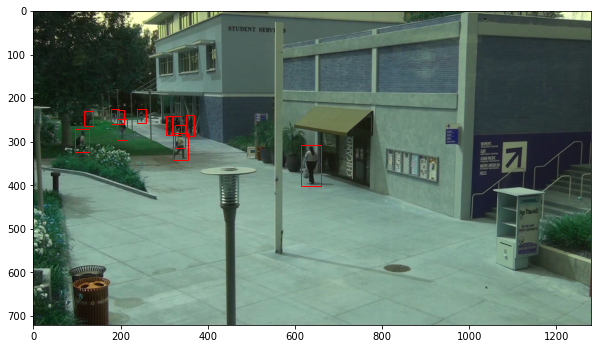

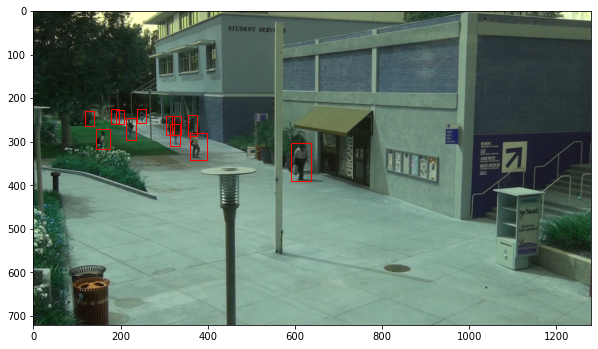

In [7]:
# View data to see some annotated frames
display.display_annotated_frame(current_video["path"], objects_df, 180)
display.display_annotated_frame(current_video["path"], objects_df, 200)

## Load Pretrained Model

In [8]:
model = yolo.yolov5()

Using cache found in /home/sardarchitect/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-30 Python-3.11.3 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)



requirements: /home/sardarchitect/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [9]:
#preds = yolo.predict_video(model, current_video['path'], is_df=True)
#preds.head()

total_precision = []
total_recall = []
for current_frame in range(current_video['num_frames']):
    bbox_pred = preds[preds['current_frame'] == current_frame]
    bbox_gt = annotations_df[annotations_df['current_frame'] == current_frame]
    
    bbox_gt_match, bbox_pred_match, bbox_pred_ious, bbox_pred_labels = evaluation.match_bboxes(bbox_gt, bbox_pred)
    precision, recall = evaluation.precision_recall(bbox_gt, bbox_pred, bbox_pred_labels)
    total_precision.append(precision)
    total_recall.append(recall)

average_precision = sum(total_precision) / len(total_precision)
average_recall = sum(total_recall) / len(total_recall)

print(average_precision)
print(average_recall)

## Organize Directories

In [10]:
# See 20230512_YOLO Format Conversion.ipynb to see code for converting VIRAT data directories to YOLO format

## Train

In [11]:
#!python ../yolov5/train.py --img 640 --batch 16 --epochs 3 --data ../scripts/dataset.yaml --cfg ../scripts/yolov5s.yaml --weights yolov5s.pt --name streetstudy --cache

## Test

In [12]:
pass

## Postprocessing

### Pedestrian Count

In [13]:
pedestrian_count = objects_df['object_id'].unique()
print(len(pedestrian_count))

37


### Video Duration

In [14]:
print(current_video['duration'], "seconds")

78 seconds


### Footpath Density

In [15]:
%matplotlib inline

In [16]:
import glob
from PIL import Image

def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("outputs/heatmap.gif", format="GIF", append_images=frames, save_all=True, duration=200, loop=0)

def display_heatmap_gif(video_path, annotations_df):
    capture = cv.VideoCapture(video_path)
    total_frame_numbers = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
    
    sel_frames = [x for x in range(0, total_frame_numbers, total_frame_numbers//60)]
    i = 0
    while True:
        success, frame = capture.read()
        if not success:
            break
        current_frame_number = int(capture.get(cv.CAP_PROP_POS_FRAMES))
        if current_frame_number in sel_frames:
            current_frame_annotations = annotations_df[annotations_df['current_frame'] < current_frame_number]
            i += 1
            display.display_heatmap(current_frame_annotations, frame, save_path=f"outputs/{current_frame_number}.png")

# display_heatmap_gif(current_video['path'], annotations_df)
# make_gif('outputs')

In [17]:
events_df

event_id  event_type  duration  start_frame  end_frame  ...  \
31           5           9       935            0        934  ...   
32           5           9       935            0        934  ...   
33           5           9       935            0        934  ...   
34           5           9       935            0        934  ...   
35           5           9       935            0        934  ...   
...        ...         ...       ...          ...        ...  ...   
3922        11           9       354         1517       1870  ...   
3940        12           9        18         1853       1870  ...   
3923        11           9       354         1517       1870  ...   
3941        12           9        18         1853       1870  ...   
3569        10           9       776         1095       1870  ...   

      bbox_lefttop_y  bbox_width  bbox_height  bbox_center_x  bbox_center_y  
31               346         122          216          897.0          454.0  
32               344         122          216          895.0          452.0  
33               344         120          216          894.0          452.0  
34               344         120          213          892.0          450.5  
35               344         120          213          890.0          450.5  
...              ...         ...          ...            ...            ...  
3922             287          90          147          617.0          360.5  
3940             459         142          259         1130.0          588.5  
3923             287          90          147          617.0          360.5  
3941             457         142          261         1126.0          587.5  
3569             231          54          102          318.0          282.0  

[8529 rows x 12 columns]

<Figure size 720x576 with 0 Axes>

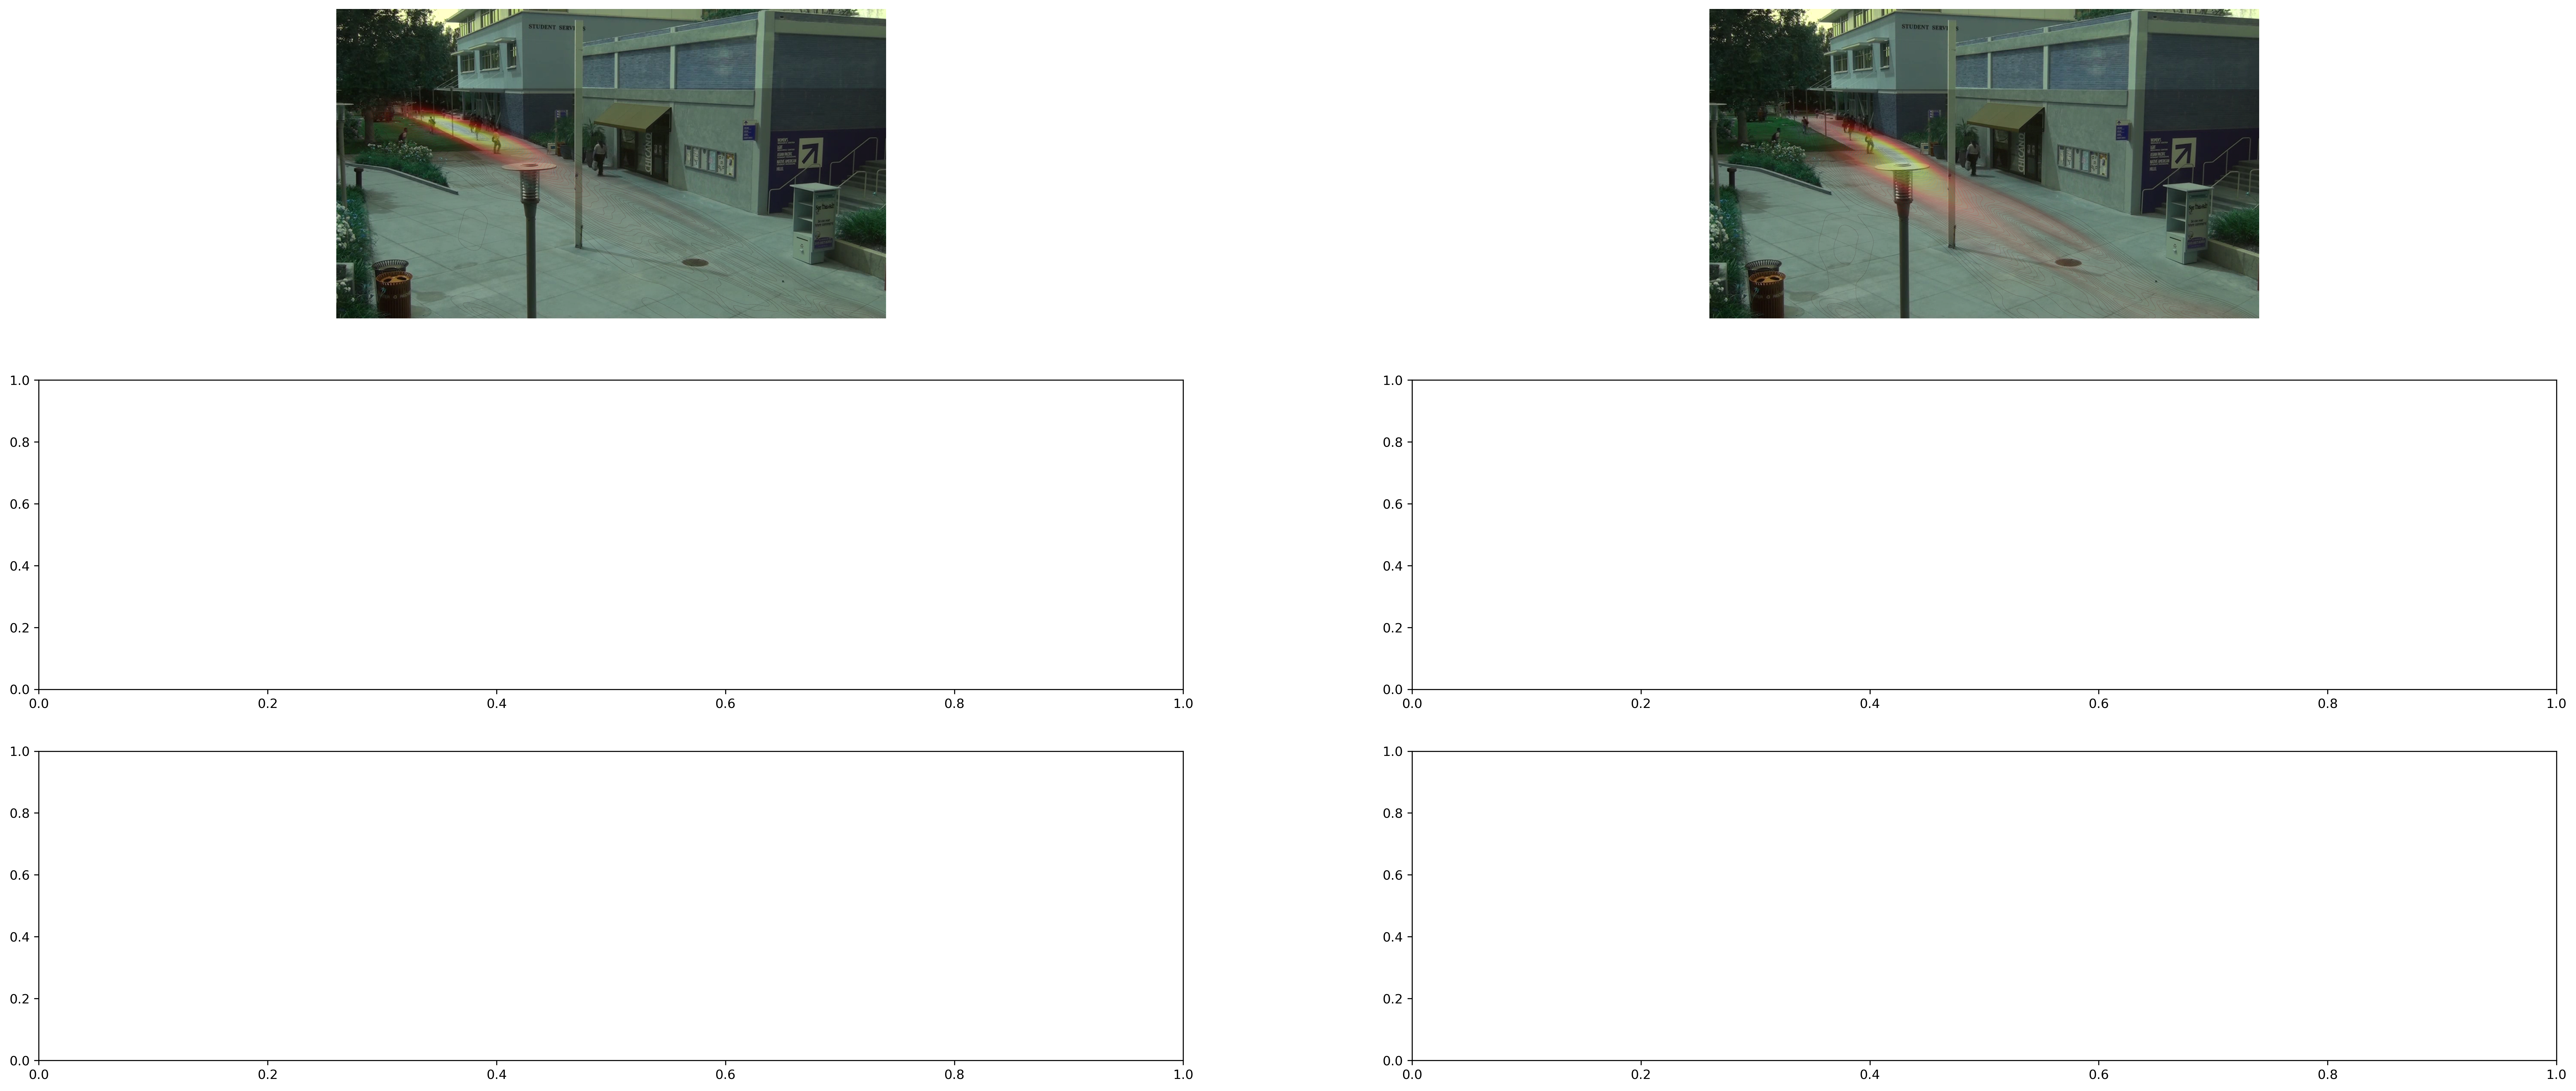

In [18]:
capture = cv.VideoCapture(current_video['path'])
while True:
    success, frame = capture.read()
    if not success:
        break
    current_frame_number = int(capture.get(cv.CAP_PROP_POS_FRAMES))
    if current_frame_number == 200:
        plt.figure(figsize=(10,8))
        fig, ax = plt.subplots(3, 2)
        ax[0][0] = display.display_heatmap(objects_df, frame, fig, ax[0][0])
        ax[0][1] = display.display_heatmap(events_df, frame, fig, ax[0][1])
        plt.show()

### Activity Density

In [19]:
events_df = virat.get_annotations_df(current_video['path'], type='events')
events_df.head()

event_id  event_type  duration  start_frame  end_frame  ...  \
0         4           7        31         1092       1122  ...   
1         4           7        31         1092       1122  ...   
2         4           7        31         1092       1122  ...   
3         4           7        31         1092       1122  ...   
4         4           7        31         1092       1122  ...   

   bbox_lefttop_y  bbox_width  bbox_height  bbox_center_x  bbox_center_y  
0             411         160          237          992.0          529.5  
1             411         164          240          997.0          531.0  
2             413         166          240         1001.0          533.0  
3             415         170          240         1007.0          535.0  
4             415         166          240         1008.0          535.0  

[5 rows x 12 columns]

In [26]:
print(events_df['event_id'].unique())
print(events_df['event_type'].unique())
object_id_list = objects_df['object_id'].unique()

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[7 9]


In [21]:
events_df['bbox_center_x'] = events_df['bbox_lefttop_x'] + (events_df['bbox_width'] / 2)
events_df['bbox_center_y'] = events_df['bbox_lefttop_y'] + (events_df['bbox_height'] / 2)
events_df.head()

event_id  event_type  duration  start_frame  end_frame  ...  \
0         4           7        31         1092       1122  ...   
1         4           7        31         1092       1122  ...   
2         4           7        31         1092       1122  ...   
3         4           7        31         1092       1122  ...   
4         4           7        31         1092       1122  ...   

   bbox_lefttop_y  bbox_width  bbox_height  bbox_center_x  bbox_center_y  
0             411         160          237          992.0          529.5  
1             411         164          240          997.0          531.0  
2             413         166          240         1001.0          533.0  
3             415         170          240         1007.0          535.0  
4             415         166          240         1008.0          535.0  

[5 rows x 12 columns]

### Directions

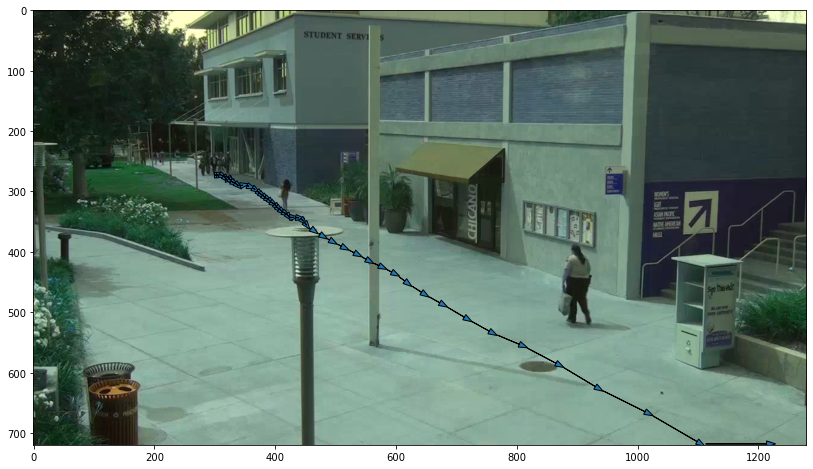

In [27]:
obj_df = objects_df[objects_df['object_id'] == object_id_list[5]]
x = obj_df['bbox_center_x']
y = obj_df['bbox_center_y'] + (obj_df['bbox_height'] / 2)

fig = plt.figure(figsize=(16,8))
step = 25
i = 0
while True:
    if i+step >= len(x):
        break
    X = x.iloc[i]
    Y = y.iloc[i]
    X_next = x.iloc[i + step]
    Y_next = y.iloc[i + step]
    dX = X_next - X
    dY = Y_next - Y
    
    plt.arrow(X, Y, dX, dY, length_includes_head=True, head_starts_at_zero=True, head_width=10)
    plt.gca().invert_yaxis()
    i = i + step
plt.imshow(frame)


### Individual Paths

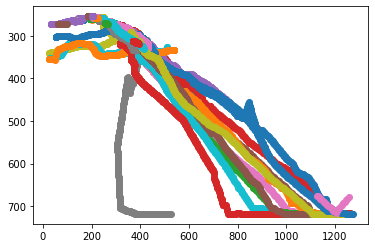

In [31]:
def person_path(object_id, annotations_df):
    obj_df = objects_df[objects_df['object_id'] == obj]
    feet_x = obj_df['bbox_center_x']
    feet_y = obj_df['bbox_center_y'] + (obj_df['bbox_height'] / 2)
    
#     fig, ax = plt.subplots()
    plt.scatter(feet_x, feet_y)
    plt.gca().invert_yaxis()
                            
object_id_list = objects_df['object_id'].unique()
for obj in object_id_list:
    person_path(obj, objects_df)
    
# Color based on activity 
# Add some filtering options so user can decide what they want to see


### Dwell Times